In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.colors as colors

from datetime import datetime
import calendar
import holidays
import datetime

import os
import requests
from zipfile import ZipFile
from io import BytesIO

import ipywidgets as widgets
from IPython.display import display, clear_output, IFrame
import time
import asyncio

from html2image import Html2Image
import seaborn as sns

from scipy.stats import fligner
from scipy.stats import shapiro, bartlett, ttest_ind, mannwhitneyu
from scipy.stats import ks_2samp

from scipy.signal import find_peaks
from scipy.stats import cumfreq

import folium
from folium.plugins import HeatMap

#### Open/Save data

In [2]:
tc = pd.read_csv('result3/tc.csv', low_memory=False)
data_all_uf = pd.read_csv('result3/data_all.csv', low_memory=False) # data trips that start or ends at orange and purple region
sp_trips_uf = pd.read_csv('result3/sp_trips.csv', low_memory=False) # data trips between the some of the stations in the orange and purple that are connected to each other

In [3]:
columns_to_drop = ["gender", "ride_id", "rideable_type", "start_station_name", "end_station_name", "start station name", "end station name", "bikeid", "birth year", "usertype"]

data_all_uf = data_all_uf.drop(columns=columns_to_drop)
sp_trips_uf = sp_trips_uf.drop(columns=columns_to_drop)

In [4]:
# side_1 = [6,44,536,206,20,23,529,460,151,43,48,192,157,7,193,24,561,31,236,65,136,135,35,374,64,19,426,193,481]
# side_2 = [60,198,72,141,239,472,471,67,179,398,235,323,107,479,80,380,178,234,544,105,117,557,91,335,177,75,139,68,76,386,515,119,195,87,97,413]

side_1 = [6,206,20,23,151,43,48,192,157,7,218,24,31,186,65,136,135,35,374,64,22,163]
side_2 = [60,228,72,141,189,67,179,185,318,107,80,380,178,184,105,117,91,335,177,75,139,68,76,116,225,87,97]

side_right = np.unique(side_1).tolist()
side_left  = np.unique(side_2).tolist()
target_nodes =  np.unique(side_left + side_right)

In [5]:
# sp_trips = sp_trips[sp_trips['start station id'].isin(target_nodes) & sp_trips['end station id'].isin(target_nodes)]
data_all2 = data_all_uf[data_all_uf['start station id'].isin(target_nodes) & data_all_uf['end station id'].isin(target_nodes)]
tc2 = tc[tc['start station id'].isin(target_nodes) & tc['end station id'].isin(target_nodes)]

In [6]:
## Filter age <46 
sp_trips_uf = sp_trips_uf.copy()
data_all_uf = data_all_uf.copy()
sp_dir_all = sp_trips_uf.copy()

In [7]:
sp_trips_uf = sp_trips_uf[sp_trips_uf['start station id'].isin(side_right) & sp_trips_uf['end station id'].isin(side_left)]

________________________________________________

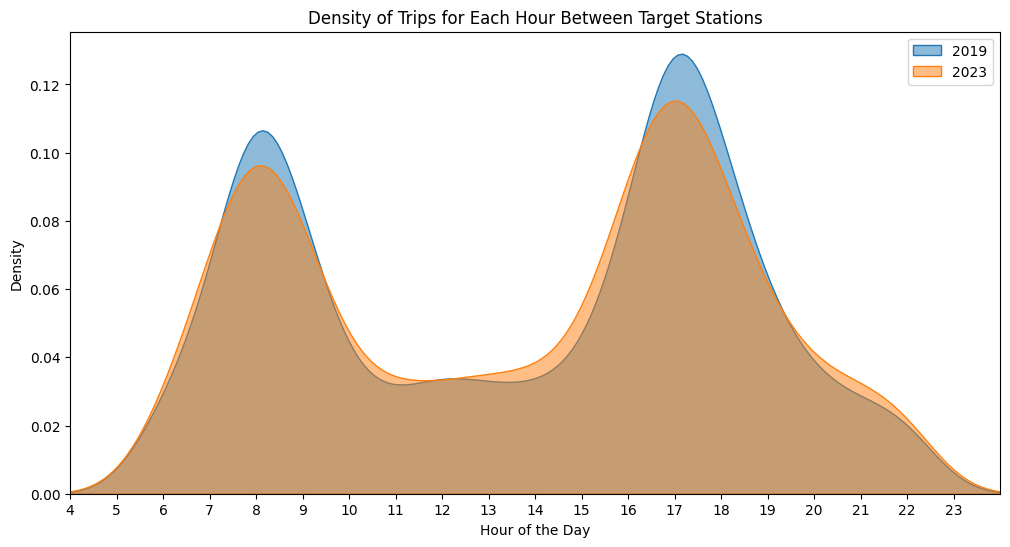

In [8]:
data_2019 = sp_trips_uf[(sp_trips_uf['year'] == 2019)]
data_2023 = sp_trips_uf[sp_trips_uf['year'] == 2023]

# Plotting the KDEs
plt.figure(figsize=(12, 6))
sns.kdeplot(data_2019['hour'], label='2019', fill=True, common_norm=False, alpha=0.5)

sns.kdeplot(data_2023['hour'], label='2023', fill=True, common_norm=False, alpha=0.5)

plt.xlabel('Hour of the Day')
plt.ylabel('Density')
plt.title('Density of Trips for Each Hour Between Target Stations')
plt.xticks(range(24))
plt.xlim(4, 24)
plt.legend()
plt.show()

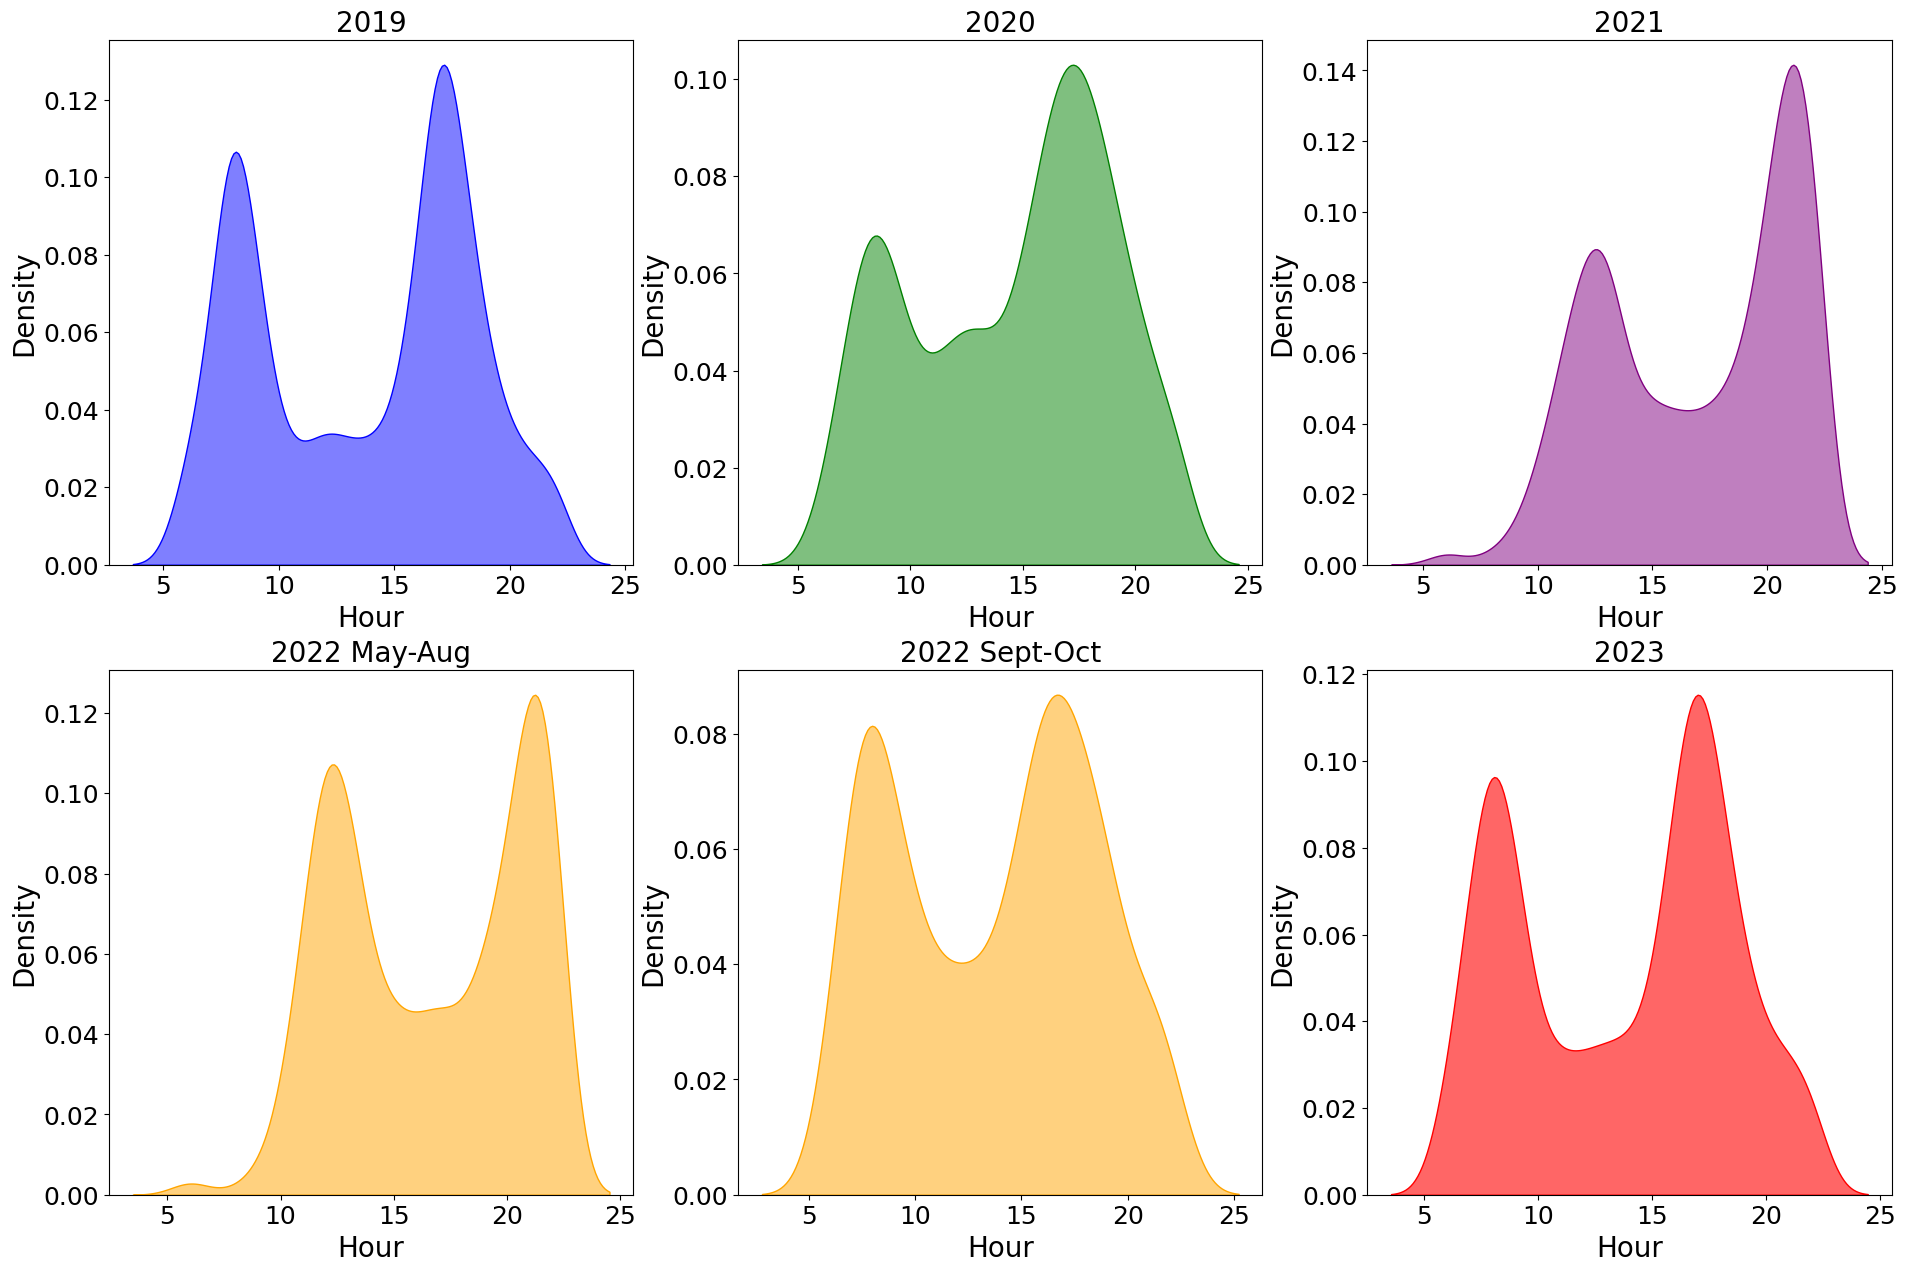

In [9]:
data_2019 = sp_trips_uf[(sp_trips_uf['year'] == 2019)]
data_2020 = sp_trips_uf[(sp_trips_uf['year'] == 2020)]
data_2021 = sp_trips_uf[(sp_trips_uf['year'] == 2021)]
data_2022 = sp_trips_uf[(sp_trips_uf['year'] == 2022)&(sp_trips_uf['month'].isin([5,6,7,8]))]
data_2022_2= sp_trips_uf[(sp_trips_uf['year'] == 2022)&(sp_trips_uf['month'].isin([9,10]))]
data_2023 = sp_trips_uf[(sp_trips_uf['year'] == 2023)]


# Plotting KDEs with different colors for each year
fig, axes = plt.subplots(2, 3, figsize=(23, 15), sharex=False)

# 2019 - Blue
sns.kdeplot(data_2019['hour'], ax=axes[0,0], fill=True, common_norm=False, alpha=0.5, color='blue')
axes[0,0].set_title('2019', fontsize=20)
axes[0,0].set_ylabel('Density', fontsize=20)
axes[0,0].set_xlabel('Hour', fontsize=20)  # Increase X-axis label font size
axes[0,0].tick_params(axis='both', labelsize=18)

# 2020 - Green
sns.kdeplot(data_2020['hour'], ax=axes[0,1], fill=True, common_norm=False, alpha=0.5, color='green')
axes[0,1].set_title('2020', fontsize=20)
axes[0,1].set_ylabel('Density', fontsize=20)
axes[0,1].set_xlabel('Hour', fontsize=20) 
axes[0,1].tick_params(axis='both', labelsize=18)

# 2021 - Purple
sns.kdeplot(data_2021['hour'], ax=axes[0,2], fill=True, common_norm=False, alpha=0.5, color='purple')
axes[0,2].set_title('2021', fontsize=20)
axes[0,2].set_ylabel('Density', fontsize=20)
axes[0,2].set_xlabel('Hour', fontsize=20)  
axes[0,2].tick_params(axis='both', labelsize=18)

# 2022 May-Aug - Orange
sns.kdeplot(data_2022['hour'], ax=axes[1,0], fill=True, common_norm=False, alpha=0.5, color='orange')
axes[1,0].set_title('2022 May-Aug', fontsize=20)
axes[1,0].set_ylabel('Density', fontsize=20)
axes[1,0].set_xlabel('Hour', fontsize=20)  
axes[1,0].tick_params(axis='both', labelsize=18)

# 2022 Sept-Oct - Cyan
sns.kdeplot(data_2022_2['hour'], ax=axes[1,1], fill=True, common_norm=False, alpha=0.5, color='orange')
axes[1,1].set_title('2022 Sept-Oct', fontsize=20)
axes[1,1].set_ylabel('Density', fontsize=20)
axes[1,1].set_xlabel('Hour', fontsize=20)  
axes[1,1].tick_params(axis='both', labelsize=18)

# 2023 - Red
sns.kdeplot(data_2023['hour'], ax=axes[1,2], fill=True, common_norm=False, alpha=0.6, color='red')
axes[1,2].set_title('2023', fontsize=20)
axes[1,2].set_ylabel('Density', fontsize=20)
axes[1,2].set_xlabel('Hour', fontsize=20) 
axes[1,2].tick_params(axis='both', labelsize=18)

# Customize the overall figure title
# plt.suptitle('Density of Trips for Each Hour Between Target Stations', fontsize=20)
# Create the folder if it doesn't exist
folder_name = "boston hour comparison"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Define the file name and path
file_path = os.path.join(folder_name, 'hour_comparison.png')

plt.savefig(file_path, bbox_inches='tight')

plt.show()

---------------------------------------------------------------------------------------------

## Filter percipitation

In [10]:
# percp_19 = pd.read_csv('percp_19_boston.csv')
percp_19 = pd.read_csv('percp_19_boston.csv')
percp_23 = pd.read_csv('percp_23_boston.csv')

percp_19['date'] = pd.to_datetime(percp_19[['year', 'month', 'day']])
percp_19 = percp_19[percp_19['date'].dt.weekday < 5]
percp_19 = percp_19.drop(columns=['date'])

percp_23['date'] = pd.to_datetime(percp_23[['year', 'month', 'day']])
percp_23 = percp_23[percp_23['date'].dt.weekday < 5]
percp_23 = percp_23.drop(columns=['date'])

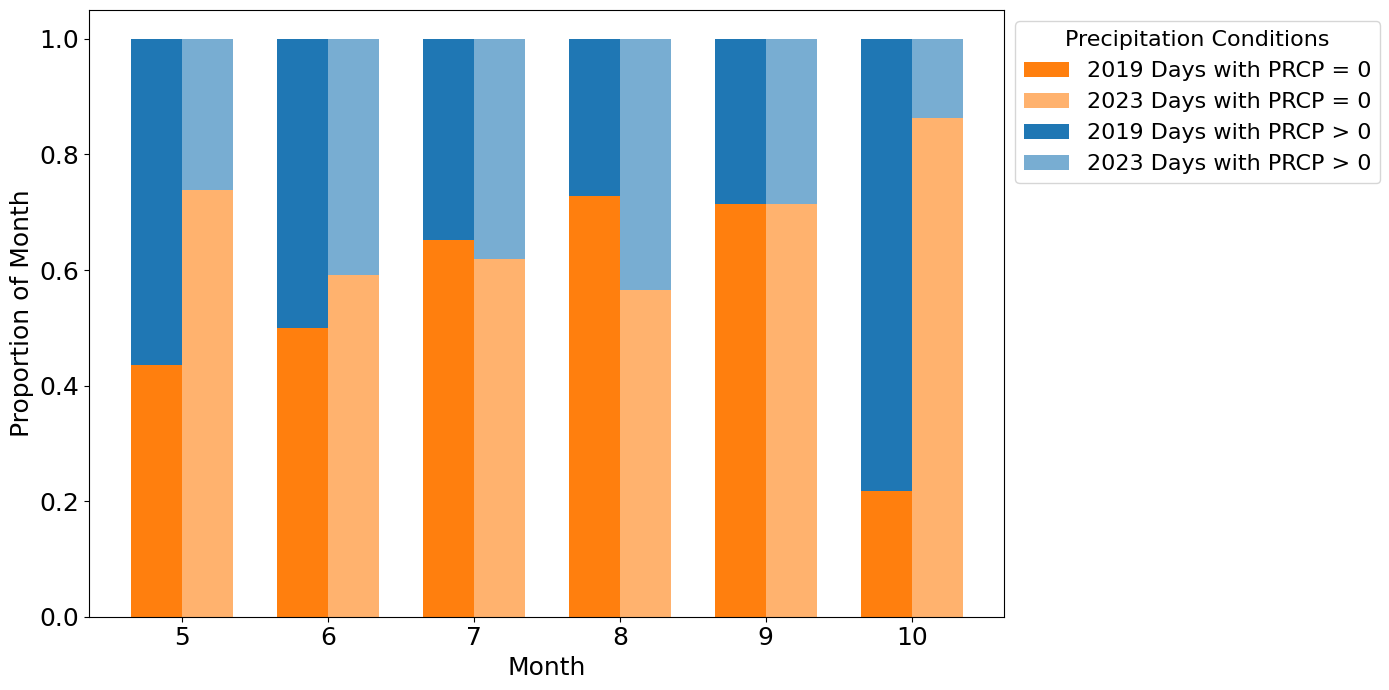

In [11]:
conditions = {
    'PRCP = 0': lambda x: x['PRCP (Inches)'] == 0,
    # '0 < PRCP <= 0.1': lambda x: (x['PRCP (Inches)'] > 0) & (x['PRCP (Inches)'] <= 0.1),
    'PRCP > 0': lambda x: x['PRCP (Inches)'] > 0
}

labels = {
    'PRCP = 0': 'Days with PRCP = 0',
    # '0 < PRCP <= 0.1': 'Days with 0 < PRCP <= 0.1',
    'PRCP > 0': 'Days with PRCP > 0'
}

color_map = {
    'PRCP = 0': 'tab:orange',
    # '0 < PRCP <= 0.1': 'tab:green',
    'PRCP > 0': 'tab:blue'
}

counts_2019 = {condition: [] for condition in conditions}
counts_2023 = {condition: [] for condition in conditions}

total_days_2019 = percp_19.groupby('month').size()
total_days_2023 = percp_23.groupby('month').size()

for month in range(5, 11):
    percp_19_month = percp_19[percp_19['month'] == month]
    percp_23_month = percp_23[percp_23['month'] == month]
    for label, condition in conditions.items():
        counts_2019[label].append(percp_19_month[condition(percp_19_month)].shape[0] / total_days_2019[month])
        counts_2023[label].append(percp_23_month[condition(percp_23_month)].shape[0] / total_days_2023[month])

df_2019 = pd.DataFrame(counts_2019, index=range(5, 11))
df_2023 = pd.DataFrame(counts_2023, index=range(5, 11))

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))
width = 0.35 

bottom_2019 = np.zeros(len(df_2019))
bottom_2023 = np.zeros(len(df_2023))

for condition, label in labels.items():
    color = color_map[condition]
    ax.bar(df_2019.index - width/2, df_2019[condition], width, bottom=bottom_2019, label=f'2019 {label}', color=color)
    ax.bar(df_2023.index + width/2, df_2023[condition], width, bottom=bottom_2023, label=f'2023 {label}', color=color, alpha=0.6)
    bottom_2019 += df_2019[condition]
    bottom_2023 += df_2023[condition]

# ax.set_xlabel('Month')
# ax.set_ylabel('Proportion of Month')
# ax.set_title('Boston Monthly Precipitation Proportion Comparison: 2019 vs 2023 (Weekday)')
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Precipitation Conditions')

ax.set_xlabel('Month', fontsize=18)
ax.set_ylabel('Proportion of Month', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)  
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Precipitation Conditions', fontsize=16, title_fontsize=16)

plt.xticks(range(5, 11))
plt.tight_layout()
plt.show()


In [12]:
def filter_weather(sp_trips_df, percp_19, percp_23, months, hours, precip_threshold=0):
    
    sp_trips_df = sp_trips_df[sp_trips_df['month'].isin(months)&sp_trips_df['hour'].isin(hours)] 
    sp_19 = sp_trips_df[sp_trips_df['year'] == 2019].copy()
    sp_23 = sp_trips_df[sp_trips_df['year'] == 2023].copy()

    sp_19 = pd.merge(sp_19, percp_19[['day', 'month', 'PRCP (Inches)']], on=['day', 'month'], how='left')
    sp_23 = pd.merge(sp_23, percp_23[['day', 'month', 'PRCP (Inches)']], on=['day', 'month'], how='left')
    sp_all = pd.concat([sp_19, sp_23])

    # Fill missing values with 100 (arbitrary big number to indicate no data)
    sp_19['PRCP (Inches)'] = sp_19['PRCP (Inches)'].fillna(100)
    sp_23['PRCP (Inches)'] = sp_23['PRCP (Inches)'].fillna(100)

    #dry
    sp_19_nice = sp_19[(sp_19['PRCP (Inches)'] == precip_threshold)]
    sp_23_nice = sp_23[(sp_23['PRCP (Inches)'] == precip_threshold)]
    sp_trips_nice = pd.concat([sp_19_nice, sp_23_nice])

    #wet
    sp_19_wet = sp_19[(sp_19['PRCP (Inches)'] != precip_threshold)]
    sp_23_wet = sp_23[(sp_23['PRCP (Inches)'] != precip_threshold)]
    # sp_19_wet = sp_19[(sp_19['PRCP (Inches)'] >precip_threshold)&(sp_19['PRCP (Inches)'] <=0.1)]
    # sp_23_wet = sp_23[(sp_23['PRCP (Inches)'] > precip_threshold)&(sp_23['PRCP (Inches)'] <=0.1)]
    sp_trips_wet = pd.concat([sp_19_wet, sp_23_wet])

    return sp_19_nice, sp_23_nice, sp_trips_nice, sp_19_wet, sp_23_wet, sp_trips_wet, sp_all

In [13]:
def days_without_precipitation(df):
    return df[(df['PRCP (Inches)'] == 0) & (df['month'].isin(range(5, 11)))].groupby(['year', 'month']).size()

ndry_19 = days_without_precipitation(percp_19).reset_index(name='dry_days')
ndry_23 = days_without_precipitation(percp_23).reset_index(name='dry_days')

In [14]:
def days_with_precipitation(df):
    return df[(df['PRCP (Inches)'] > 0) & (df['month'].isin(range(5, 11)))].groupby(['year', 'month']).size()

nwet_19 = days_with_precipitation(percp_19).reset_index(name='wet_days')
nwet_23 = days_with_precipitation(percp_23).reset_index(name='wet_days')

In [15]:
months = range(5,11)
hours = range(6,23)
sp_trips_19, sp_trips_23, sp_trips, sp_trips_w19, sp_trips_w23, sp_trips_wet, sp_all = filter_weather(sp_trips_uf, percp_19, percp_23, months, hours)
data_19, data_23, data_all_nice, data_w19, data_w23, data_all_wet, data_all= filter_weather(data_all_uf, percp_19, percp_23, months, hours)
# data_19_nice2, data_23_nice2, data_all_nice2, all_192, all_232= filter_weather(data_all, percp_19, percp_23, months, hours)

sp_all_19, sp_all_23, sp_all_trips, sp_all_trips_w19, sp_all_trips_w23, sp_all_trips_wet, sp_all_all = filter_weather(sp_dir_all, percp_19, percp_23, months, hours)


## Trips per day

### Fill missing days

In [16]:
daily_19 = sp_trips_19.groupby(['day', 'month']).size().reset_index(name='daily_trip')
daily_23 = sp_trips_23.groupby(['day', 'month']).size().reset_index(name='daily_trip')

daily_19_w = sp_trips_w19.groupby(['day', 'month']).size().reset_index(name='daily_trip')
daily_23_w = sp_trips_w23.groupby(['day', 'month']).size().reset_index(name='daily_trip')

In [17]:
def check_num_days(df, df_num, col_name):
    num_days = df.groupby(['month']).size().reset_index(name='num_days')
    diff_df = pd.DataFrame([])
    diff_df['month'] = df_num['month']
    diff_df['diff'] = df_num[col_name] - num_days['num_days']
    return diff_df

In [18]:
def add_fake_days(data, month, num_days):
    # Start adding fake days from day 32 to fill the dry days without trip
    num_days = int(num_days)
    start_day = 32
    fake_days = pd.DataFrame({
        'day': range(start_day, start_day + num_days),
        'month': month,
        'daily_trip': [0] * num_days
    })
    return pd.concat([data, fake_days], ignore_index=True)

In [19]:
## Update dataset with the days without bike trips
datasets = {
    'daily_23': (ndry_23, 'dry_days'),
    'daily_19': (ndry_19, 'dry_days'),
}

results = {}
for key, (ndry_df, col_name) in datasets.items():
    current_data = globals()[key]  # Access the dataset by name
    diff_df = check_num_days(current_data, ndry_df, col_name)  # Calculate the difference
    for index, row in diff_df.iterrows():
        if row['diff'] > 0:
            current_data = add_fake_days(current_data, row['month'], row['diff'])
    results[key] = current_data  # Store the modified data

daily_23, daily_19 = (results['daily_23'], results['daily_19'])

In [20]:
datasets = {
    'daily_23_w': (nwet_23, 'wet_days'),
    'daily_19_w': (nwet_19, 'wet_days'),
}

results = {}
for key, (nwet_df, col_name) in datasets.items():
    current_data = globals()[key]  # Access the dataset by name
    diff_df = check_num_days(current_data, nwet_df, col_name)  # Calculate the difference
    for index, row in diff_df.iterrows():
        if row['diff'] > 0:
            current_data = add_fake_days(current_data, row['month'], row['diff'])
    results[key] = current_data  # Store the modified data

daily_23_w, daily_19_w = (results['daily_23_w'], results['daily_19_w'])

### Comparison and significance test

In [21]:
def get_significance(p_value):
    if p_value > 0.1:
        return 'ns'
    elif p_value > 0.05:
        return '.'
    elif p_value <= 0.001:
        return '***'
    elif p_value <= 0.01:
        return '**'
    else:
        return '*'

In [22]:
def mon_med(df):
    return df.groupby('month')['daily_trip'].median().reset_index(name='med_daily_trip')

In [23]:
def mu_ks_test(df_19, df_23):
    mu_p_values = []
    ks_p_values = []
    for month in sorted(df_19['month'].unique()):
        data_19 = df_19[df_19['month'] == month]['daily_trip']
        data_23 = df_23[df_23['month'] == month]['daily_trip']

        # MU Test
        _, mu_p_value = mannwhitneyu(data_19, data_23, alternative='two-sided')
        mu_p_values.append(mu_p_value)
        
        # KS Test
        _, ks_p_value = ks_2samp(data_19, data_23)
        ks_p_values.append(ks_p_value)
        
    return mu_p_values, ks_p_values

In [24]:
def diff_test(median_19, median_23, mu_p_values, ks_p_values):
    merged = pd.merge(median_19, median_23, on='month', suffixes=('_19', '_23'))
    merged['difference(%)'] = np.round((merged['med_daily_trip_23'] - merged['med_daily_trip_19'])/merged['med_daily_trip_19']*100)
    merged['mu_p_value'] = mu_p_values
    merged['ks_p_value'] = ks_p_values
    merged['mu_significance'] = merged['mu_p_value'].apply(get_significance)
    merged['ks_significance'] = merged['ks_p_value'].apply(get_significance)
    return merged[['month', 'med_daily_trip_19', 'med_daily_trip_23', 'difference(%)', 'mu_p_value', 'mu_significance', 'ks_p_value', 'ks_significance']]

In [25]:
# Year comparison DRY
med_daily_23 = mon_med(daily_23)
med_daily_19 = mon_med(daily_19)

mu_p_values, ks_p_values = mu_ks_test(daily_19, daily_23)

results_dry = diff_test(med_daily_19, med_daily_23, mu_p_values, ks_p_values)
results_dry

,month,med_daily_trip_19,med_daily_trip_23,difference(%),mu_p_value,mu_significance,ks_p_value,ks_significance
0,5,54.0,45.0,-17.0,0.062479,.,0.158120,ns
1,6,64.0,50.0,-22.0,0.000710,***,0.000806,***
2,7,62.0,55.0,-11.0,0.030065,*,0.047017,*
3,8,77.0,61.0,-21.0,0.000480,***,0.000862,***
4,9,74.0,56.0,-24.0,0.000095,***,0.000353,***
5,10,65.0,56.0,-14.0,0.617790,ns,0.464333,ns


In [26]:
# Year comparison WET
med_daily_23_w = mon_med(daily_23_w)
med_daily_19_w = mon_med(daily_19_w)

mu_p_values_w, ks_p_values_w = mu_ks_test(daily_19_w, daily_23_w)

results_w = diff_test(med_daily_19_w, med_daily_23_w, mu_p_values_w, ks_p_values_w)
results_w

,month,med_daily_trip_19,med_daily_trip_23,difference(%),mu_p_value,mu_significance,ks_p_value,ks_significance
0,5,49.0,41.0,-16.0,0.159979,ns,0.148607,ns
1,6,53.5,44.0,-18.0,0.045171,*,0.030267,*
2,7,61.0,36.5,-40.0,0.013450,*,0.018648,*
3,8,62.0,43.5,-30.0,0.057310,.,0.125125,ns
4,9,66.5,34.0,-49.0,0.132035,ns,0.142857,ns
5,10,52.0,45.0,-13.0,0.174564,ns,0.465414,ns


In [27]:
# Weather Comparison
def diff_test_weather(median_dry, median_wet, mu_p_values, ks_p_values):
    merged = pd.merge(median_dry, median_wet, on='month', suffixes=('_dry', '_wet'))
    merged['difference(%)'] = np.round((merged['med_daily_trip_wet'] - merged['med_daily_trip_dry'])/merged['med_daily_trip_dry']*100)
    merged['mu_p_value'] = mu_p_values
    merged['ks_p_value'] = ks_p_values
    merged['mu_significance'] = merged['mu_p_value'].apply(get_significance)
    merged['ks_significance'] = merged['ks_p_value'].apply(get_significance)
    return merged[['month', 'med_daily_trip_dry', 'med_daily_trip_wet', 'difference(%)', 'mu_p_value', 'mu_significance', 'ks_p_value', 'ks_significance']]

# 2019
mu_p_values_19, ks_p_values_19 = mu_ks_test(daily_19, daily_19_w)
results_weather_19 = diff_test_weather(med_daily_19, med_daily_19_w, mu_p_values_19, ks_p_values_19)
results_weather_19

,month,med_daily_trip_dry,med_daily_trip_wet,difference(%),mu_p_value,mu_significance,ks_p_value,ks_significance
0,5,54.0,49.0,-9.0,0.263579,ns,0.435991,ns
1,6,64.0,53.5,-16.0,0.044832,*,0.052448,.
2,7,62.0,61.0,-2.0,0.583044,ns,0.486482,ns
3,8,77.0,62.0,-19.0,0.082760,.,0.201413,ns
4,9,74.0,66.5,-10.0,0.127628,ns,0.419542,ns
5,10,65.0,52.0,-20.0,0.247733,ns,0.140688,ns


In [28]:
# 2023
mu_p_values_23, ks_p_values_23 = mu_ks_test(daily_23, daily_23_w)
results_weather_23 = diff_test_weather(med_daily_23, med_daily_23_w, mu_p_values_23, ks_p_values_23)
results_weather_23

,month,med_daily_trip_dry,med_daily_trip_wet,difference(%),mu_p_value,mu_significance,ks_p_value,ks_significance
0,5,45.0,41.0,-9.0,0.233027,ns,0.326062,ns
1,6,50.0,44.0,-12.0,0.331123,ns,0.325202,ns
2,7,55.0,36.5,-34.0,0.026838,*,0.019195,*
3,8,61.0,43.5,-29.0,0.021656,*,0.071024,.
4,9,56.0,34.0,-39.0,0.035379,*,0.065900,.
5,10,56.0,45.0,-20.0,0.136979,ns,0.171429,ns


## Trips  Comparison 

In [29]:
def count_trips(data_sp, data, side_right, side_left, waifw_mode=False):

    rl = data_sp[(data_sp['start station id'].isin(side_right)) & (data_sp['end station id'].isin(side_left))].groupby(['day', 'month']).size()
    lr = data_sp[(data_sp['start station id'].isin(side_left)) & (data_sp['end station id'].isin(side_right))].groupby(['day', 'month']).size()
    rr = data[(data['start station id'].isin(side_right)) & (data['end station id'].isin(side_right))].groupby(['day', 'month']).size()
    ll = data[(data['start station id'].isin(side_left)) & (data['end station id'].isin(side_left))].groupby(['day', 'month']).size()
    
    if waifw_mode:
        total_rl = int(rl.sum())  
        total_lr = int(lr.sum())  
        total_rr = int(rr.sum())  
        total_ll = int(ll.sum())  
        return total_rl, total_lr, total_rr, total_ll
       
    else:
        return rl,lr,rr,ll


def add_zero_trip(trip_counts, total_dry_days):
    for key in trip_counts:
        num_zeros = total_dry_days - len(trip_counts[key])
        if num_zeros > 0:
            zero_series = pd.Series([0] * num_zeros)
            trip_counts[key] = pd.concat([trip_counts[key], zero_series])
    return trip_counts

def the_stat_tests(data1, data2):
    if len(data1) == 0 or len(data2) == 0:
        return (np.nan, np.nan, 'NA', np.nan, np.nan, 'NA')
    ks_stat, ks_p = ks_2samp(data1, data2)
    mw_stat, mw_p = mannwhitneyu(data1, data2, alternative='two-sided')
    ks_sign = get_significance(ks_p)
    mw_sign = get_significance(mw_p)
    return (ks_stat, ks_p, ks_sign, mw_stat, mw_p, mw_sign)

def mad(data):
    return np.median(np.abs(data - np.median(data)))

def plot_heatmap(data, annotations, title, ax, ks_significances, mw_significances, show_legend=False, fmt=".2f"):
    sns.heatmap(data, annot=annotations, fmt=fmt, cmap="YlGnBu", annot_kws={"size": 12}, linewidths=.5, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('To Direction')
    ax.set_ylabel('From Direction')
    ax.set_xticklabels(['West', 'East'])
    ax.set_yticklabels(['West', 'East'])
    if show_legend:
        legend_text = f'From - To \n'\
                      f'KS: LL = {ks_significances[0][0]}, LR = {ks_significances[0][1]}, RL = {ks_significances[1][0]}, RR = {ks_significances[1][1]}\n' \
                      f'MW: LL = {mw_significances[0][0]}, LR = {mw_significances[0][1]}, RL = {mw_significances[1][0]}, RR = {mw_significances[1][1]}'
        ax.annotate(legend_text, xy=(0.5, -0.2), xycoords='axes fraction', ha='center', va='top', fontsize=10, color='black')

In [30]:
def plot_trip_comparison(sp_trips, da, hour_range, title_suffix, month_range=range(5, 13), side_right=None, side_left=None, dry=True):
    
    def filter_data(year):
        return (sp_trips[(sp_trips['year'] == year) & (sp_trips['hour'].isin(hour_range)) & (sp_trips['month'].isin(month_range))],
                da[(da['year'] == year) & (da['hour'].isin(hour_range)) & (da['month'].isin(month_range))])
    
    t19, n19 = filter_data(2019)
    t23, n23 = filter_data(2023)
        
    rl_19, lr_19, rr_19, ll_19 = count_trips(t19, n19, side_right, side_left)
    rl_23, lr_23, rr_23, ll_23 = count_trips(t23, n23, side_right, side_left)

    ## ADD THE DAYS WITHOUT BIKING
    # total days no rain
    if dry==1:
        total_dry_19 = ndry_19[ndry_19['month'].isin(month_range)]['dry_days'].sum()
        total_dry_23 = ndry_23[ndry_23['month'].isin(month_range)]['dry_days'].sum()
    else:
        total_dry_19 = nwet_19[nwet_19['month'].isin(month_range)]['wet_days'].sum()
        total_dry_23 = nwet_23[nwet_23['month'].isin(month_range)]['wet_days'].sum()
 
    trip_counts_19 = {'rl_19': rl_19, 'lr_19': lr_19, 'rr_19': rr_19, 'll_19': ll_19}
    trip_counts_23 = {'rl_23': rl_23, 'lr_23': lr_23, 'rr_23': rr_23, 'll_23': ll_23}
    
    
    trip_counts_19 = add_zero_trip(trip_counts_19, total_dry_19)
    trip_counts_23 = add_zero_trip(trip_counts_23, total_dry_23)
    rl_19, lr_19, rr_19, ll_19 = trip_counts_19.values()
    rl_23, lr_23, rr_23, ll_23 = trip_counts_23.values()


    _, _, ks_sign_rl, _, _, mw_sign_rl = the_stat_tests(rl_19, rl_23)
    _, _, ks_sign_lr, _, _, mw_sign_lr = the_stat_tests(lr_19, lr_23)
    _, _, ks_sign_rr, _, _, mw_sign_rr = the_stat_tests(rr_19, rr_23)
    _, _, ks_sign_ll, _, _, mw_sign_ll = the_stat_tests(ll_19, ll_23)


    med_matrix_19 = np.array([[np.median(ll_19), np.median(lr_19)], [np.median(rl_19), np.median(rr_19)]])
    med_matrix_23 = np.array([[np.median(ll_23), np.median(lr_23)], [np.median(rl_23), np.median(rr_23)]])

    mad_matrix_19 = np.array([[mad(ll_19), mad(lr_19)], [mad(rl_19), mad(rr_19)]])
    mad_matrix_23 = np.array([[mad(ll_23), mad(lr_23)], [mad(rl_23), mad(rr_23)]])

    annotations_19 = np.array([[f"{med_matrix_19[0, 0]:.2f}\n({mad_matrix_19[0, 0]:.2f})", 
                                f"{med_matrix_19[0, 1]:.2f}\n({mad_matrix_19[0, 1]:.2f})"],
                               [f"{med_matrix_19[1, 0]:.2f}\n({mad_matrix_19[1, 0]:.2f})", 
                                f"{med_matrix_19[1, 1]:.2f}\n({mad_matrix_19[1, 1]:.2f})"]])

    annotations_23 = np.array([[f"{med_matrix_23[0, 0]:.2f}\n({mad_matrix_23[0, 0]:.2f})", 
                                f"{med_matrix_23[0, 1]:.2f}\n({mad_matrix_23[0, 1]:.2f})"],
                               [f"{med_matrix_23[1, 0]:.2f}\n({mad_matrix_23[1, 0]:.2f})", 
                                f"{med_matrix_23[1, 1]:.2f}\n({mad_matrix_23[1, 1]:.2f})"]])

    growth_matrix = (med_matrix_23 - med_matrix_19)/med_matrix_19 

    ks_sm = np.array([[ks_sign_ll, ks_sign_lr], [ks_sign_rl, ks_sign_rr]])
    mw_sm = np.array([[mw_sign_ll, mw_sign_lr], [mw_sign_rl, mw_sign_rr]])

    fig, axes = plt.subplots(1, 3, figsize=(23, 6))
    empty_significance = [['', ''], ['', '']]  # Empty array for no significance display
    plot_heatmap(med_matrix_19, annotations_19, f'Median and MAD Daily Trips 2019 ({title_suffix})', axes[0], empty_significance, empty_significance, fmt="")
    plot_heatmap(med_matrix_23, annotations_23, f'Median and MAD Daily Trips 2023 ({title_suffix})', axes[1], empty_significance, empty_significance, fmt="")
    plot_heatmap(growth_matrix, growth_matrix, f'Difference Median Normalized ({title_suffix})', axes[2], ks_sm, mw_sm, show_legend=True)
    plt.tight_layout()
    plt.show()

In [32]:
import scipy.linalg as la

def waifw_matrix(sp_trips, da, hour_range, title_suffix, month_range=range(5, 13), side_right=None, side_left=None):
    
    def filter_data(year):
        return (sp_trips[(sp_trips['year'] == year) & (sp_trips['hour'].isin(hour_range)) & (sp_trips['month'].isin(month_range))],
                da[(da['year'] == year) & (da['hour'].isin(hour_range)) & (da['month'].isin(month_range))])
    
    t19, n19 = filter_data(2019)
    t23, n23 = filter_data(2023)
        
    rl_19, lr_19, rr_19, ll_19 = count_trips(t19, n19, side_right, side_left, waifw_mode=True)
    rl_23, lr_23, rr_23, ll_23 = count_trips(t23, n23, side_right, side_left, waifw_mode=True)

    matrix_19 = np.array([[(ll_19), (lr_19)], [(rl_19), (rr_19)]])
    matrix_23 = np.array([[(ll_23), (lr_23)], [(rl_23), (rr_23)]])

    m19_norms = matrix_19 / matrix_19.sum()
    m23_norms = matrix_23 / matrix_23.sum()

    diff = m23_norms - m19_norms

    # Calculate eigenvalues
    eigval_19 = np.round(np.real(la.eigvals(m19_norms)), 3)
    eigval_23 = np.round(np.real(la.eigvals(m23_norms)), 3)
    
    # Spectral gap
    sg_19 = max(eigval_19) / min(eigval_19)
    sg_23 = max(eigval_23) / min(eigval_23)
    
    # Corrected Q-statistic using diagonal elements
    q_diag_19 = (np.sum(np.diag(m19_norms)) - 1/len(m19_norms)) / (1 - 1/len(m19_norms))
    q_diag_23 = (np.sum(np.diag(m23_norms)) - 1/len(m23_norms)) / (1 - 1/len(m23_norms))

    # Create a DataFrame to store eigenvalues and other metrics
    eigen_df = pd.DataFrame({
        'Year': ['2019', '2023'],
        'Eigenvalue 1': [eigval_19[0], eigval_23[0]],
        'Eigenvalue 2': [eigval_19[1], eigval_23[1]],
        'Spectral Gap': [sg_19, sg_23],
        'Q-Statistic': [q_diag_19, q_diag_23],
    })

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    sns.heatmap(m19_norms, annot=True, fmt=".4f", cmap="YlGnBu", ax=axes[0], annot_kws={"size": 20}, cbar=False) #cbar_kws={'label': 'Normalized Value', 'shrink': 0.8, 'aspect': 0.8})
    axes[0].set_title(f'2019 {title_suffix}', fontsize=20)
    axes[0].set_xlabel('To Direction', fontsize=20)
    axes[0].set_ylabel('From Direction', fontsize=20)
    axes[0].set_xticklabels(['West', 'East'], fontsize=20)
    axes[0].set_yticklabels(['West', 'East'], fontsize=20)
    
    sns.heatmap(m23_norms, annot=True, fmt=".4f", cmap="YlGnBu", ax=axes[1], annot_kws={"size": 20}, cbar=False) #cbar_kws={'label': 'Normalized Value', 'shrink': 0.8, 'aspect': 0.8})
    axes[1].set_title(f'2023 {title_suffix}', fontsize=20)
    axes[1].set_xlabel('To Direction', fontsize=20)
    axes[1].set_ylabel('From Direction', fontsize=20)
    axes[1].set_xticklabels(['West', 'East'], fontsize=20)
    axes[1].set_yticklabels(['West', 'East'], fontsize=20)
    
    sns.heatmap(diff, annot=True, fmt=".4f", cmap="YlGnBu", ax=axes[2], annot_kws={"size": 20}, cbar_kws={'label': '', 'ticks': [], 'shrink': 0.8, 'aspect': 10})
    axes[2].set_title(f'Difference Matrix (2023 - 2019)', fontsize=20)
    axes[2].set_xlabel('To Direction', fontsize=20)
    axes[2].set_ylabel('From Direction', fontsize=20)
    axes[2].set_xticklabels(['West', 'East'], fontsize=20)
    axes[2].set_yticklabels(['West', 'East'], fontsize=20)

    plt.tight_layout() 
    plt.show()

    return eigen_df

In [33]:
#Change here to change the weather 
ddry = True

if ddry==1:
    sp_trips_nice = sp_trips
    sp_all_nice = sp_all_trips

elif ddry==0:
    sp_trips_nice = sp_trips_wet
    sp_all_nice = sp_all_trips_wet

## WAIFW 

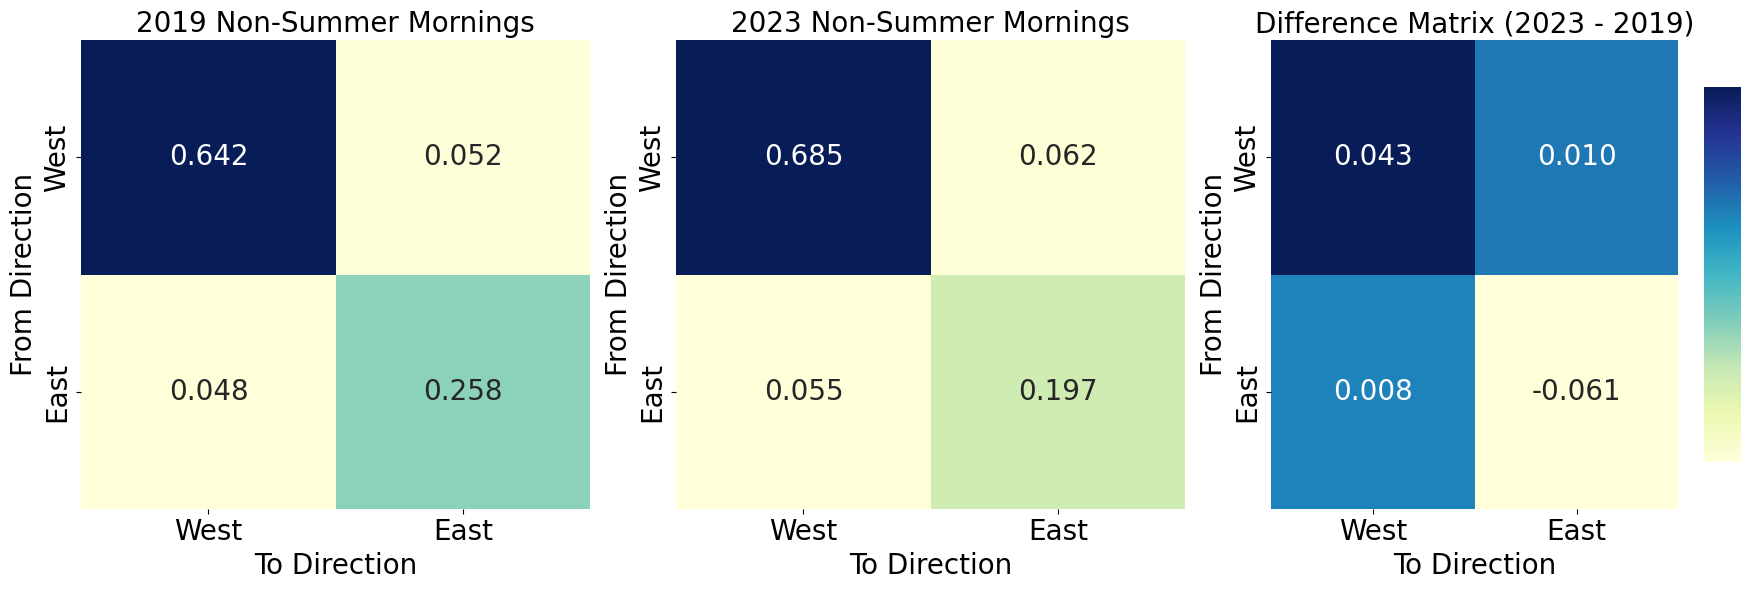

In [38]:
a=waifw_matrix(sp_all_nice, data_all_nice, hour_range=range(7, 11), title_suffix="Non-Summer Mornings", month_range=[5,9,10], side_right=side_right, side_left=side_left)

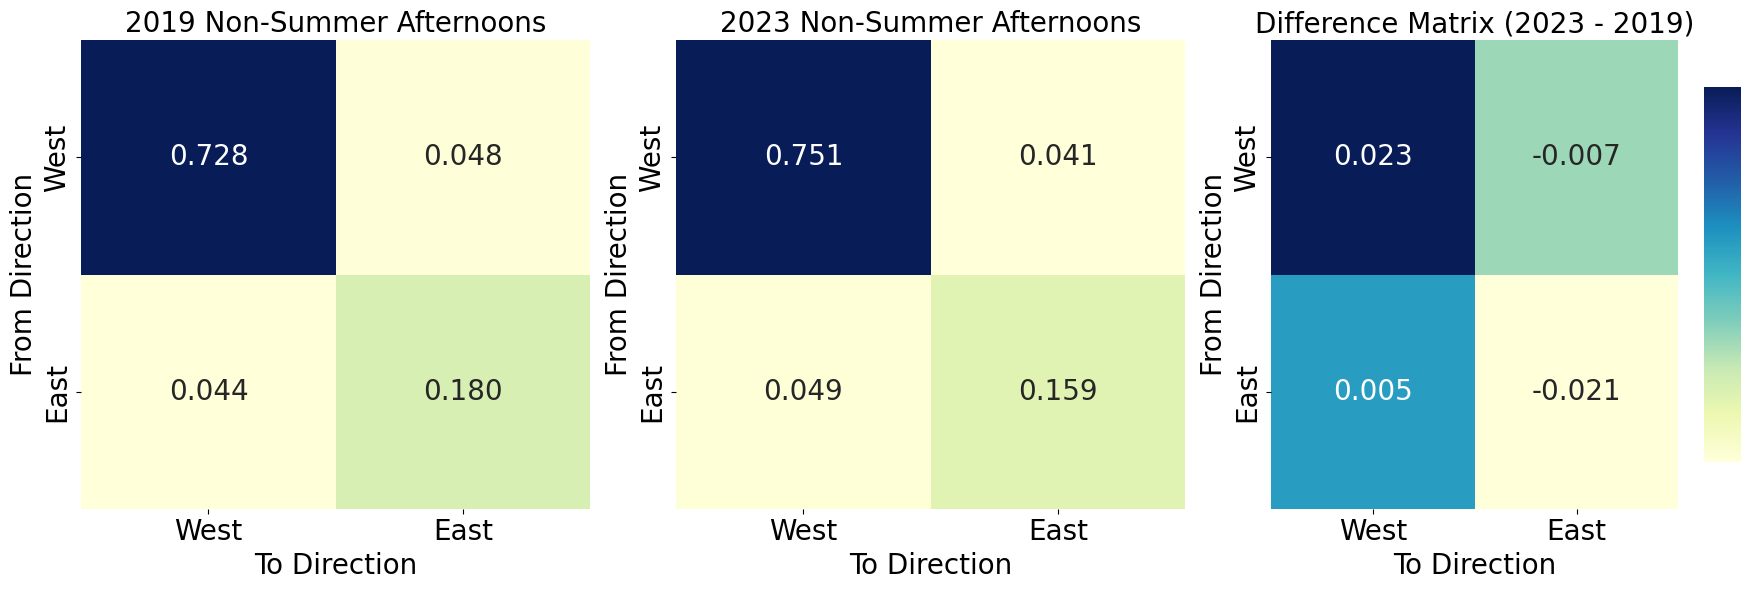

In [39]:
a=waifw_matrix(sp_all_nice, data_all_nice, hour_range=range(16, 21), title_suffix="Non-Summer Afternoons", month_range=[5,9,10], side_right=side_right, side_left=side_left)

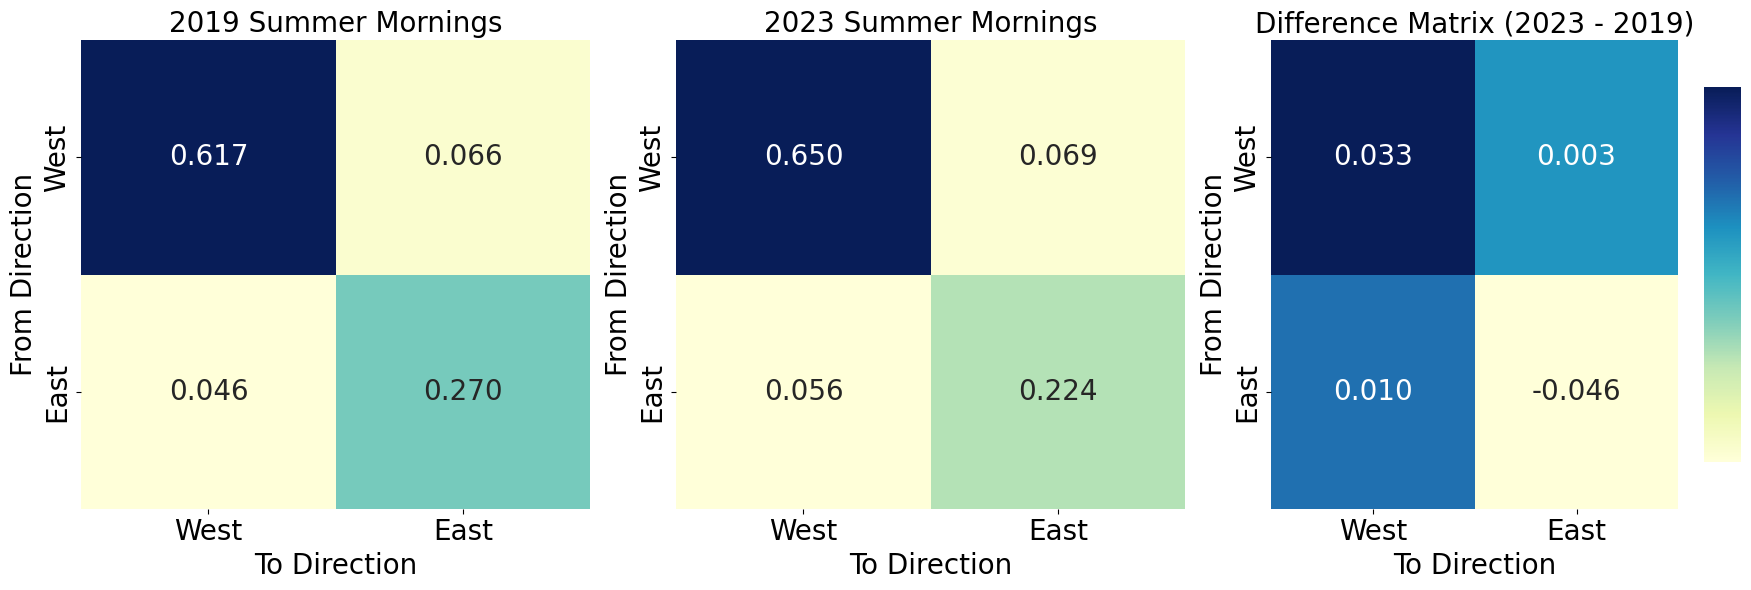

In [40]:
a=waifw_matrix(sp_all_nice, data_all_nice, hour_range=range(7, 11), title_suffix="Summer Mornings", month_range=[6,7,8], side_right=side_right, side_left=side_left)

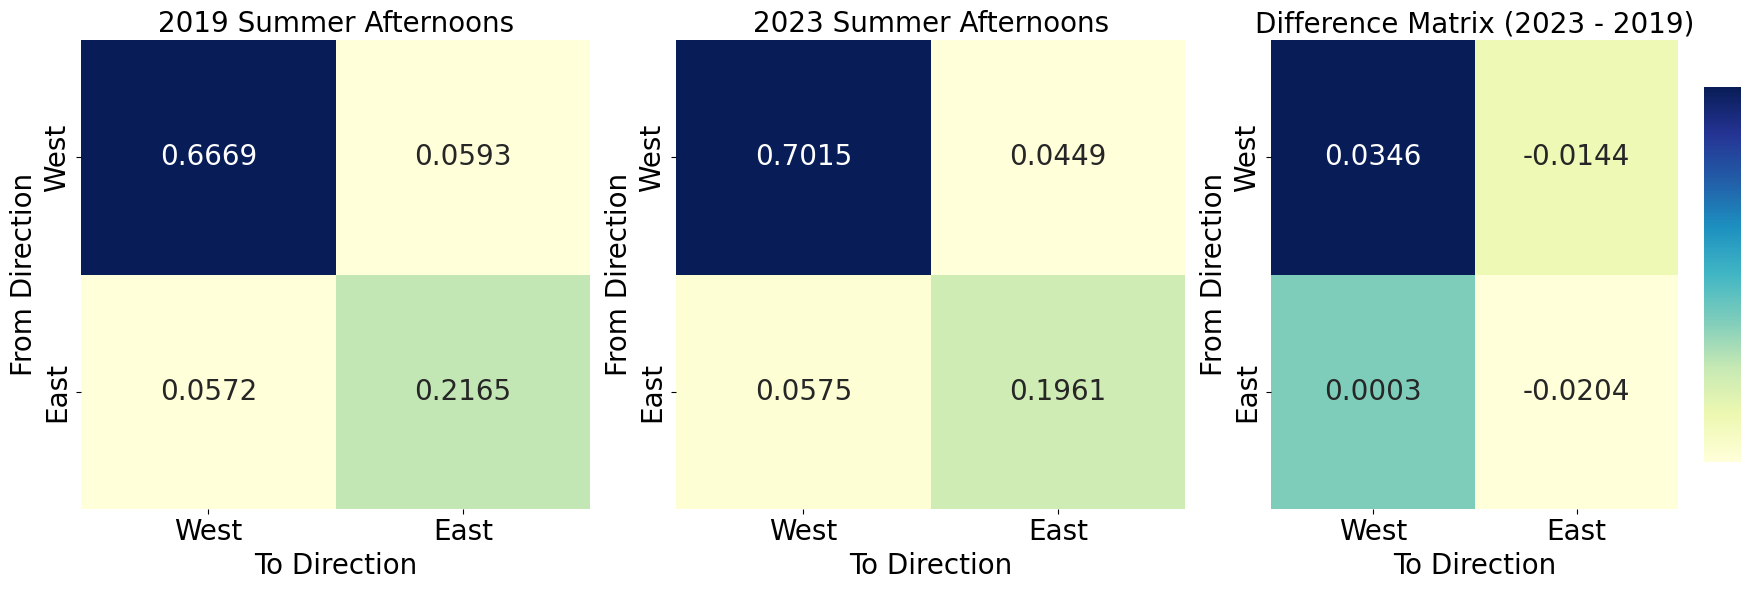

In [34]:
a=waifw_matrix(sp_all_nice, data_all_nice, hour_range=range(16, 21), title_suffix="Summer Afternoons", month_range=[6,7,8], side_right=side_right, side_left=side_left)

## Distance Analysis Functions

In [35]:
def aggregate_time_groups(data, hours, months, year, median_calc = True, year_filt = True):
    start_hour = min(hours)
    end_hour = max(hours)
    

    filter_condition = (
        (data['hour'] >= start_hour) &
        (data['hour'] < end_hour) &
        (data['month'].isin(months))
    )
    if year_filt:
        filter_condition &= (data['year'] == year)

    filtered_data = data[filter_condition]
        
    if median_calc==True:
        aggregated_data = filtered_data.groupby(['start station id', 'end station id'])['median duration'].median().reset_index()
        return filtered_data, aggregated_data
    else:
        return filtered_data

In [36]:
all_dist = pd.read_csv("all_trips_distance_boston.csv")

In [37]:
def merge_distance (df_data, df_distance):
    df_data_distance = pd.merge(df_data, df_distance[['start station id', 'end station id', 'distance (km)']], on=['start station id', 'end station id'], how='left')
    num_rows_with_nan = df_data_distance['distance (km)'].isna().sum()
    print(f"Number of rows with NaN distance values: {num_rows_with_nan}")
    return df_data_distance

In [38]:
# get the control group
data_all_nice_copy = data_all_nice.copy()
sp_trips_nice_copy = sp_trips_nice.copy()

data_all_nice_copy['unique_id'] = list(zip(
    data_all_nice_copy['starttime'],
    data_all_nice_copy['stoptime'],
    data_all_nice_copy['start station id'],
    data_all_nice_copy['end station id'],
    data_all_nice_copy['tripduration']
))

sp_trips_nice_copy['unique_id'] = list(zip(
    sp_trips_nice_copy['starttime'],
    sp_trips_nice_copy['stoptime'],
    sp_trips_nice_copy['start station id'],
    sp_trips_nice_copy['end station id'],
    sp_trips_nice_copy['tripduration']
))

control = data_all_nice_copy[~data_all_nice_copy['unique_id'].isin(sp_trips_nice_copy['unique_id'])]

## just beginning from right side 
control = control[control['start station id'].isin(side_right)]
control = control.drop(columns=['unique_id'])

In [39]:
# Data distance strictly between the targets in orange and purple region
dd = merge_distance(sp_trips_nice, all_dist)

Number of rows with NaN distance values: 0


In [40]:
# Data distance of all trips starts at Boston region
all_distance = merge_distance(control, all_dist)

Number of rows with NaN distance values: 0


In [41]:
def get_peaks(data, column, num_peaks=3):
    kde = sns.kdeplot(data[column], bw_adjust=0.8)
    kde_data = kde.get_lines()[0].get_data()
    plt.close() 
    
    peaks, _ = find_peaks(kde_data[1])
    peak_values = kde_data[0][peaks]
    peak_densities = kde_data[1][peaks]
    sorted_peaks = sorted(zip(peak_densities, peak_values), reverse=True)
    
    return [(round(peak[1], 2), round(peak[0], 2)) for peak in sorted_peaks[:num_peaks]]

In [42]:
def plot_trip_distances(df1, df2, distance_column, labels, hour_range, month_range, add, save_pic=True):

    peaks_df1 = get_peaks(df1, distance_column)
    peaks_df2 = get_peaks(df2, distance_column)

    plt.figure(figsize=(10, 6))

    sns.kdeplot(df1[distance_column], color='blue', linestyle='-', fill=True, bw_adjust=0.8, label=f'{labels[0]}')
    sns.kdeplot(df2[distance_column], color='red', linestyle='-', fill=True, bw_adjust=0.8, label=f'{labels[1]}')

    # plt.title(f'Trip Distances for {labels[0]} and {labels[1]} : hour {hour_range[0]} - {hour_range[-1]}', fontsize=16)
    # print(f'Trip Distances for {labels[0]} and {labels[1]} : hour {hour_range[0]} - {hour_range[-1]}')

    plt.xlabel('Distance (km)', fontsize=20)
    plt.ylabel('Density', fontsize=20)

    # 1st stats
    mean_df1 = df1[distance_column].mean()
    median_df1 = df1[distance_column].median()
    std_df1 = df1[distance_column].std()
    count_df1 = df1.shape[0]
    range_df1 = df1[distance_column].max() - df1[distance_column].min()

    plt.axvline(mean_df1, color='blue', linestyle='solid', linewidth=2, label=f'Mean: {mean_df1:.2f} km (N={count_df1})')
    plt.axvline(median_df1, color='blue', linestyle='dotted', linewidth=3, label=f'Median: {median_df1:.2f} km')

    # 2nd stats
    mean_df2 = df2[distance_column].mean()
    median_df2 = df2[distance_column].median()
    std_df2 = df2[distance_column].std()
    count_df2 = df2.shape[0]
    range_df2 = df2[distance_column].max() - df2[distance_column].min()

    plt.axvline(mean_df2, color='red', linestyle='solid', linewidth=2, label=f'Mean: {mean_df2:.2f} km (N={count_df2})')
    plt.axvline(median_df2, color='red', linestyle='dotted', linewidth=3, label=f'Median: {median_df2:.2f} km')

    plt.grid(axis='y', alpha=0.75)
    plt.legend(fontsize=18)  # Increase legend font size
    plt.xticks(fontsize=18)  # Increase x-axis tick font size
    plt.yticks(fontsize=18)
    plt.xlim(0, 15) 


    
    ### SAVE PICTURE
    if save_pic==True:

        folder_name = "boston_distance"
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        if ddry == 1:
            weather = 'dry'
        else:
            weather = 'rainy'
        
        if month_range[0]==5:
            season = 'non-summer'
        else:
            season = 'summer'
        
        if hour_range[0]==7:
            time_of_day = 'morning'
        else:
            time_of_day = 'afternoon'
        
        # Create the dynamic file name
        file_name = f'Dist {add} {season} {time_of_day} {weather} boston.png'
        print(f'Dist {add} {season} {time_of_day} {weather} boston')
        
        # Define the file path
        file_path = os.path.join(folder_name, file_name)
        plt.savefig(file_path, bbox_inches='tight')
    
    plt.show()

    return peaks_df1, peaks_df2

In [43]:
def rank_biserial_correlation(x, y):
    u_stat, _ = mannwhitneyu(x, y, alternative='two-sided')
    n1, n2 = len(x), len(y)
    rbc = 1 - (2 * u_stat) / (n1 * n2)
    return rbc

In [44]:
def calculate_mad(data):
    median = np.median(data)
    absolute_deviations = np.abs(data - median)
    mad = np.median(absolute_deviations)
    return mad

In [45]:
def calculate_cdf(data, num_bins=1000):
    counts, bin_edges = np.histogram(data, bins=num_bins, density=False)
    cumulative_counts = np.cumsum(counts)
    y = cumulative_counts / cumulative_counts[-1]
    x = bin_edges[1:] 
    return x, y

from scipy.integrate import cumulative_trapezoid
def calculate_integrals(x, y):
    integral_1 = cumulative_trapezoid(y, x, initial=0)
    integral_2 = cumulative_trapezoid(integral_1, x, initial=0)
    return integral_1, integral_2
    
def check_stochastic_dominance(x1, y1, x2, y2):
    integral_1_y1, integral_2_y1 = calculate_integrals(x1, y1)
    integral_1_y2, integral_2_y2 = calculate_integrals(x2, y2)

    # Check both ways
    fsd_1_2 = np.all(y2 >= y1)
    ssd_1_2 = np.all(integral_1_y2 >= integral_1_y1)
    tsd_1_2 = np.all(integral_2_y2 >= integral_2_y1)
    
    fsd_2_1 = np.all(y1 >= y2)
    ssd_2_1 = np.all(integral_1_y1 >= integral_1_y2)
    tsd_2_1 = np.all(integral_2_y1 >= integral_2_y2)
    
    return (fsd_1_2, ssd_1_2, tsd_1_2), (fsd_2_1, ssd_2_1, tsd_2_1)

In [46]:
def plot_sd(x1, y1, x2, y2, labels, legend_fontsize=14, tick_fontsize=14):
    integral_1_y1, integral_1_y2 = calculate_integrals(x1, y1)
    integral_2_y1, integral_2_y2 = calculate_integrals(x2, y2)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 7))

    # CDFs
    axes[0].plot(x1, y1, label=labels[0], color='blue')
    axes[0].plot(x2, y2, label=labels[1], color='red')
    axes[0].fill_between(x1, y1, y2, where=(y1 <= y2), color='blue', alpha=0.1)
    axes[0].fill_between(x1, y1, y2, where=(y1 > y2), color='red', alpha=0.1)
    axes[0].set_title('Cumulative Distribution Functions', fontsize=16)
    axes[0].set_xlabel('Distance (km)', fontsize=16)
    axes[0].set_ylabel('Cumulative Probability', fontsize=16)
    axes[0].legend(fontsize=legend_fontsize)
    axes[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    axes[0].grid(True)

    # 2nd-order integrals
    axes[1].plot(x1, integral_1_y1, color='blue', label=f'{labels[0]}')
    axes[1].plot(x2, integral_1_y2,color='red', label=f'{labels[1]}')
    axes[1].fill_between(x1, integral_1_y1, integral_1_y2, where=(integral_1_y1 <= integral_1_y2), color='blue', alpha=0.1)
    axes[1].fill_between(x1, integral_1_y1, integral_1_y2, where=(integral_1_y1 > integral_1_y2), color='red', alpha=0.1)
    axes[1].set_title('Second-Order Stochastic Dominance (SSD)', fontsize=16)
    axes[1].set_xlabel('Distance (km)', fontsize=16)
    axes[1].set_ylabel('Cumulative Area', fontsize=16)
    axes[1].legend(fontsize=legend_fontsize)
    axes[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    axes[1].grid(True)

    # 3rd-order integrals
    axes[2].plot(x1, integral_2_y1, color='blue', label=f'{labels[0]}')
    axes[2].plot(x2, integral_2_y2, color='red', label=f'{labels[1]}')
    axes[2].fill_between(x1, integral_2_y1, integral_2_y2, where=(integral_2_y1 <= integral_2_y2), color='blue', alpha=0.1)
    axes[2].fill_between(x1, integral_2_y1, integral_2_y2, where=(integral_2_y1 > integral_2_y2), color='red', alpha=0.1)
    axes[2].set_title('Third-Order Stochastic Dominance (TSD)', fontsize=16)
    axes[2].set_xlabel('Distance (km)', fontsize=16)
    axes[2].set_ylabel('Cumulative Area of SSD', fontsize=16)
    axes[2].legend(fontsize=legend_fontsize)
    axes[2].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

In [47]:
def stat_tests(dd1, dd2, column, label, plot_dominance=True, mutest=False):
    if mutest:
        # Mann-Whitney U Test only
        u_stat, u_p_value = mannwhitneyu(dd1[column], dd2[column], alternative='two-sided')
        u_significance = get_significance(u_p_value)
        
        test_results = {
            'Test': ['Mann-Whitney U'],
            'p-value': [u_p_value],
            'Significance': [u_significance]
        }
        test_df = pd.DataFrame(test_results)
        return test_df

    else:
        # Mann-Whitney U Test
        u_stat, u_p_value = mannwhitneyu(dd1[column], dd2[column], alternative='two-sided')
        u_significance = get_significance(u_p_value)

        # Kolmogorov-Smirnov Test
        ks_stat, ks_p_value = ks_2samp(dd1[column], dd2[column])
        ks_significance = get_significance(ks_p_value)

        # Rank-Biserial Correlation
        rbc_value = rank_biserial_correlation(dd1[column], dd2[column])

        # Calculate CDFs
        x1, cdf1 = calculate_cdf(dd1[column].values)
        x2, cdf2 = calculate_cdf(dd2[column].values)

        # Check for stochastic dominance in both directions
        dominance_1_2, dominance_2_1 = check_stochastic_dominance(x1, cdf1, x2, cdf2)

        # Save stochastic dominance results in a dictionary
        dominance_results = {
            'Stochastic Dominance': ['First-order', 'Second-order', 'Third-order'],
            '19 over 23': ['Yes' if dominance_1_2[0] else 'No', 'Yes' if dominance_1_2[1] else 'No', 'Yes' if dominance_1_2[2] else 'No'],
            '23 over 19': ['Yes' if dominance_2_1[0] else 'No', 'Yes' if dominance_2_1[1] else 'No', 'Yes' if dominance_2_1[2] else 'No']
        }
        dominance_df = pd.DataFrame(dominance_results)

        # Save test results in a dictionary
        test_results = {
            'Test': ['Mann-Whitney U', 'Kolmogorov-Smirnov', 'Rank-Biserial Correlation'],
            # 'Statistic': [u_stat, ks_stat, rbc_value],
            # 'p-value': [u_p_value, ks_p_value, 'N/A'],
            'Significance': [u_significance, ks_significance, rbc_value]
        }
        test_df = pd.DataFrame(test_results)

        if plot_dominance:
            plot_sd(x1, cdf1, x2, cdf2, label)
        
        return test_df, dominance_df

## Speed Analysis Functions

In [48]:
short_boundary = 1.6
long_boundary = 6

In [49]:
def speed_categorization(df_data, short_boundary, long_boundary):
    df_data = df_data.copy()
    df_data['speed (km/h)'] = df_data['distance (km)']/ (df_data['tripduration']/3600)
    df_data = df_data[(df_data['speed (km/h)'] <= 35)]
    df_data = df_data[(df_data['speed (km/h)'] >= 5)]
    df_data = df_data.drop_duplicates()

    # divide short (<1.5 km), med, and long trip 
    df_short = df_data[df_data['distance (km)']<short_boundary]
    df_med = df_data[((df_data['distance (km)']>=short_boundary)&(df_data['distance (km)']<=long_boundary))]
    df_long = df_data[df_data['distance (km)']>long_boundary]
    
    return df_data, df_short, df_med, df_long

In [50]:
def plot_speed(df1, df2, label1, label2, title, typ='cumsum', ax=None):
    colors = {label1: 'blue', label2: 'red'}

    combined_speed_data = pd.concat([df1['speed (km/h)'], df2['speed (km/h)']])
    _, combined_bin_edges = np.histogram(combined_speed_data, bins=15)
    min_speed = combined_bin_edges.min()
    max_speed = combined_bin_edges.max()

    for df, label in zip([df1, df2], [label1, label2]):
        speed_data = df['speed (km/h)']
        num_points = len(speed_data)

        if typ == 'density':
            sns.kdeplot(speed_data, color=colors[label], fill=True, warn_singular=False, label=f'{label} (n={num_points})', ax=ax)
            ax.set_ylabel('Density', fontsize=18)

        elif typ == 'freq':            
            ax.hist(speed_data, bins=combined_bin_edges, color=colors[label], alpha=0.5, edgecolor='black', label=f'{label} (n={num_points})', density=True)
            # ax.set_ylabel('Frequency', fontsize=12)

        elif typ == 'cumsum':
            sns.ecdfplot(speed_data, color=colors[label], linestyle='-', linewidth=2, label=f'{label} (n={num_points})', ax=ax)
            ax.set_ylabel('Cumulative Sum (Normalized)', fontsize=12)
        
        mean_speed = df['speed (km/h)'].mean()
        median_speed = df['speed (km/h)'].median()
        ax.axvline(mean_speed, color=colors[label], linestyle='solid', linewidth=3, label=f'Mean: {mean_speed:.2f}')
        ax.axvline(median_speed, color=colors[label], linestyle='dashed', linewidth=3, label=f'Median: {median_speed:.2f}')

    ax.set_title(title, fontsize=22)
    # print(title)
    ax.tick_params(axis='both', which='major', labelsize=20)

    ax.legend(fontsize=18)
    ax.grid(axis='y', alpha=0.75)
    ax.set_xlim(min_speed, max_speed)

In [51]:
def fligner_test (df_short, df_med, df_long, label):
    test_result = fligner(df_short['speed (km/h)'], df_med['speed (km/h)'], df_long['speed (km/h)'])
    # print(f'Fligner-Killeen Test for {label}')
    # print(f'p-value: {test_result.pvalue}')
    # print(f'{get_significance(test_result.pvalue)}')
    if test_result.pvalue<0.05:
        # print("DO NOT combine")
        return 0
    else:
        # print("CAN combine")
        return 1

## Run the test

In [61]:
## CHANGE HOUR AND MONTH
# hour =  range(7,11)
hour =  range(16,21)

# month = [5,9,10]
month = range(6,9)

In [62]:
boston_target = aggregate_time_groups(dd, hour, month, None, median_calc = False, year_filt=False)
boston_all = aggregate_time_groups(all_distance, hour, month, None, median_calc = False, year_filt=False)

In [63]:
## CHANGE THIS PART

dd1 = boston_target[boston_target['year']==2019]
dd2 = boston_target[boston_target['year']==2023]
labels = ['2019', '2023']



# dd1 = boston_all[boston_all['year']==2019]
# dd2 = boston_all[boston_all['year']==2023]
# labels = ['2019', '2023']

Dist target summer afternoon rainy boston


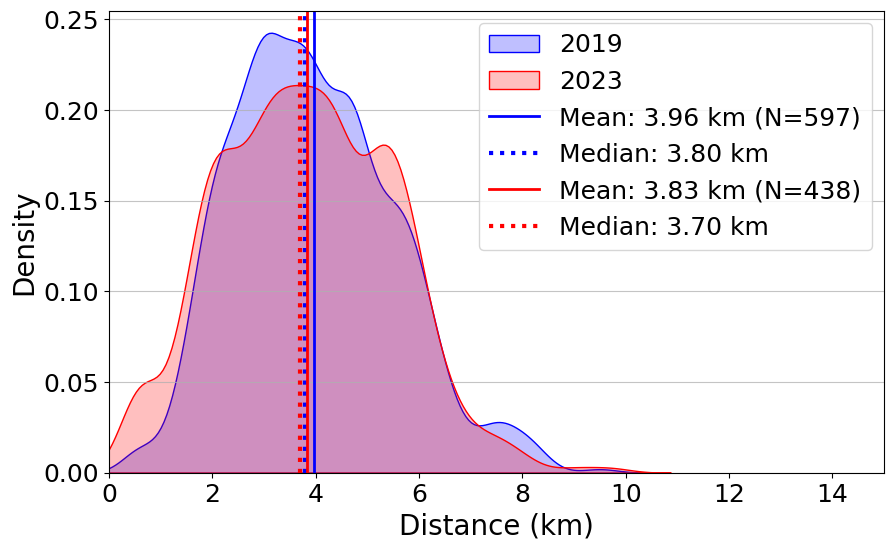

In [64]:
p1, p2 = plot_trip_distances(dd1, dd2, 'distance (km)', labels, hour, month, add='target', save_pic=True)
# 
# p1, p2 = plot_trip_distances(dd1, dd2, 'distance (km)', labels, hour, month, add='control', save_pic=True)

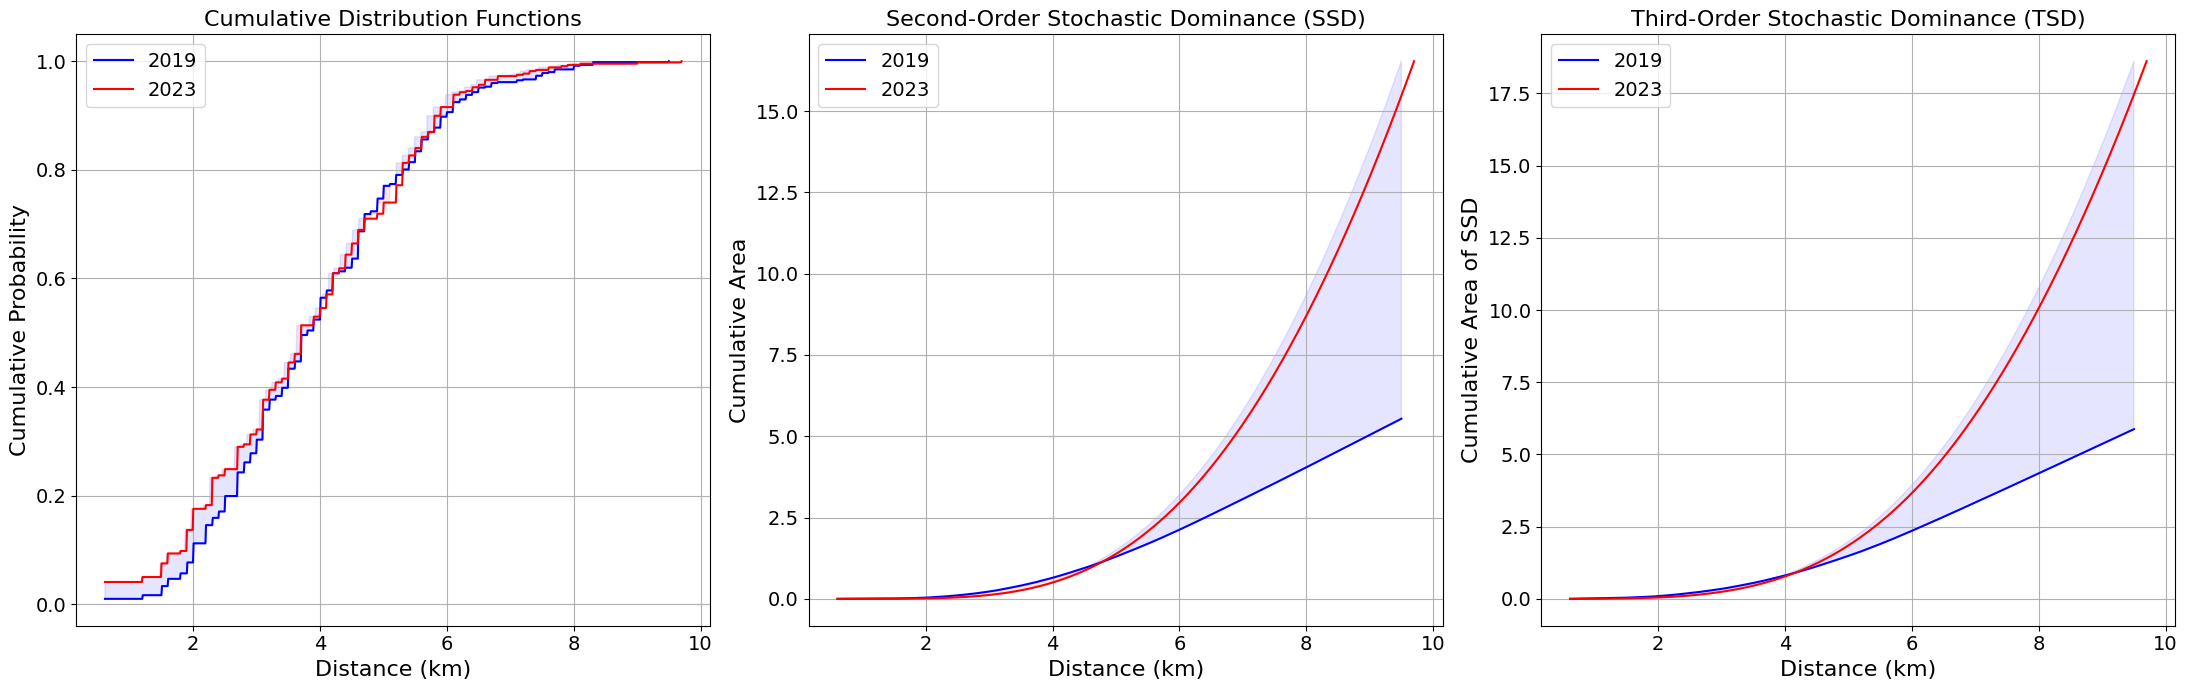

In [65]:
test_df, dominance_df = stat_tests(dd1, dd2, 'distance (km)', labels)

In [66]:
test_df

,Test,Significance
0,Mann-Whitney U,ns
1,Kolmogorov-Smirnov,ns
2,Rank-Biserial Correlation,-0.036996


In [67]:
dominance_df

,Stochastic Dominance,19 over 23,23 over 19
0,First-order,No,No
1,Second-order,Yes,No
2,Third-order,Yes,No


In [115]:
dd_f1, dd_short1, dd_med1, dd_long1 = speed_categorization(dd1, short_boundary, long_boundary)
dd_f2, dd_short2, dd_med2, dd_long2 = speed_categorization(dd2, short_boundary, long_boundary)

C:\Users\nadil\AppData\Local\Temp\ipykernel_23768\1357143450.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0.01, 0.01, 0.01, 0.01])


Speed control summer afternoon rainy boston


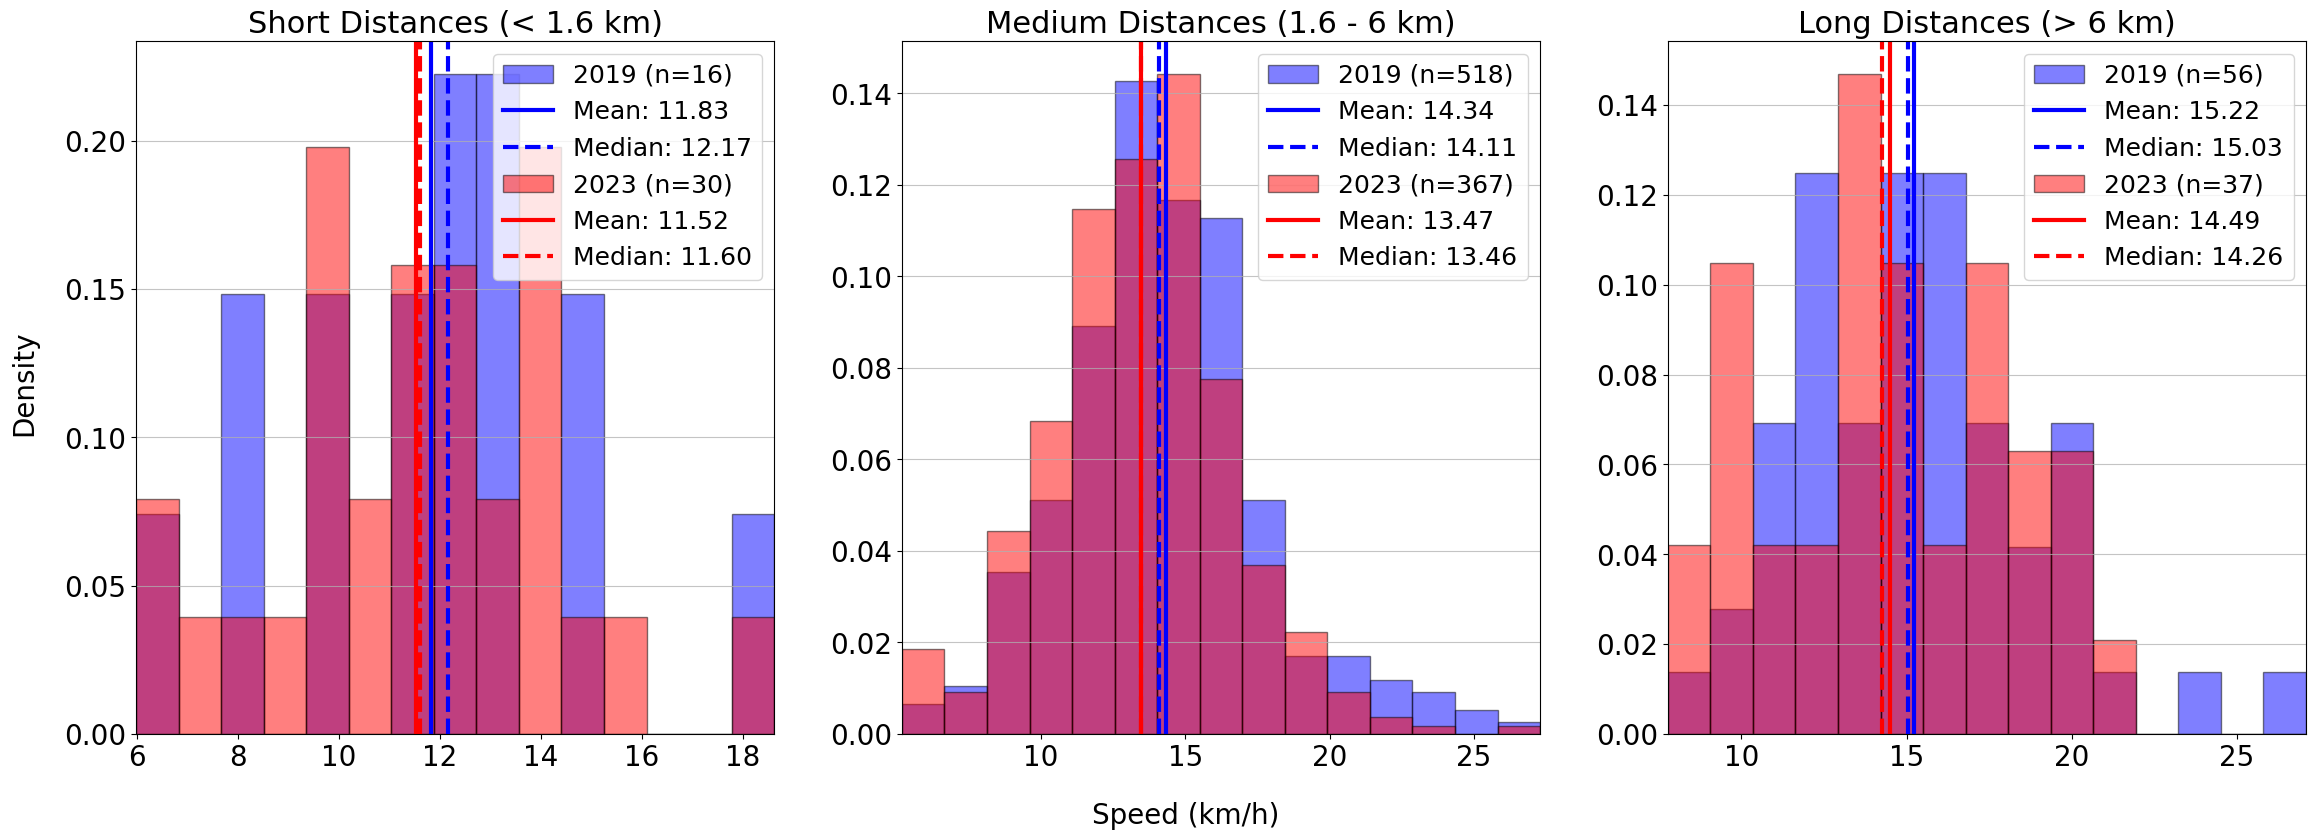

In [116]:
fig, axes = plt.subplots(1, 3, figsize=(28, 9))
typ = 'freq'

label1 = labels[0]
label2 = labels[1]

plot_speed(dd_short1, dd_short2, label1, label2, f'Short Distances (< {short_boundary} km)', typ, ax=axes[0])
plot_speed(dd_med1, dd_med2, label1, label2, f'Medium Distances ({short_boundary} - {long_boundary} km)', typ, ax=axes[1])
plot_speed(dd_long1, dd_long2, label1, label2, f'Long Distances (> {long_boundary} km)', typ, ax=axes[2])

# fig.suptitle(f'Speed Distribution for Different Distance Categories : hour {min(hour)} - {max(hour)}', fontsize=15, y=0.95)
# print(f'Speed Distribution for Different Distance Categories : hour {min(hour)} - {max(hour)}, month {min(month)} - {max(month)} ')

fig.text(0.5, 0.01, 'Speed (km/h)', ha='center', fontsize=20)
fig.text(0.08, 0.5, 'Density', va='center', rotation='vertical', fontsize=20)

plt.tight_layout(rect=[0.01, 0.01, 0.01, 0.01])



folder_name = "boston_speed"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

weather = 'dry' if ddry == 1 else 'rainy'
season = 'non-summer' if month[0] == 5 else 'summer'
time_of_day = 'morning' if hour[0] == 7 else 'afternoon'


# Create the dynamic file name
file_name = f'Speed control {season} {time_of_day} {weather} boston.png'
print(f'Speed control {season} {time_of_day} {weather} boston')

# Define the file path
file_path = os.path.join(folder_name, file_name)
plt.savefig(file_path, bbox_inches='tight')
    
plt.show()

In [117]:
t1 = stat_tests(dd_short1, dd_short2, 'speed (km/h)', plot_dominance=False, mutest=True, label=None)
t1 ['Distance Category'] = f'Short Distances'

t2 = stat_tests(dd_med1, dd_med2, 'speed (km/h)', plot_dominance=False, mutest=True, label=None)
t2['Distance Category'] = f'Medium Distances'

t3 = stat_tests(dd_long1, dd_long2, 'speed (km/h)', plot_dominance=False, mutest=True, label=None)
t3['Distance Category'] = f'Long Distances'

test_speed = pd.concat([t1, t2, t3], ignore_index=True)
# test_speed = pd.concat([t2, t3], ignore_index=True)

test_speed = test_speed.drop(columns=['Test'])
test_speed = test_speed[['Distance Category', 'p-value', 'Significance']]
test_speed

,Distance Category,p-value,Significance
0,Short Distances,0.746759,ns
1,Medium Distances,0.000529,***
2,Long Distances,0.467801,ns


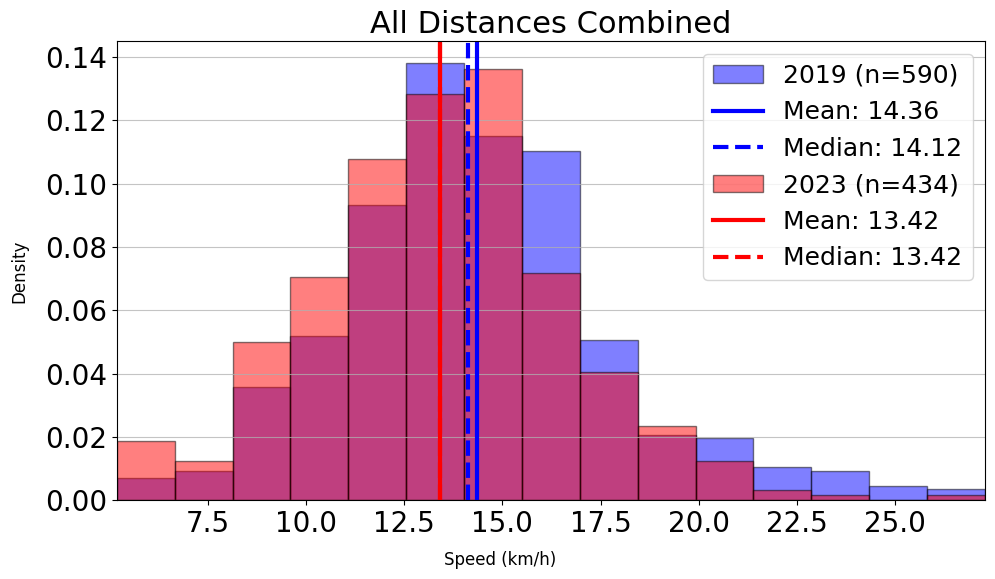

             Test   p-value Significance
0  Mann-Whitney U  0.000069          ***


In [118]:
combine_test1 = fligner_test(dd_short1, dd_med1, dd_long1, label1)
combine_test2 = fligner_test(dd_short2, dd_med2, dd_long2, label2)
if (combine_test1 == 1) & (combine_test2 == 1): #if both fligner test allows for the combination
    fig, ax = plt.subplots(figsize=(10, 6))
    plot_speed(dd_f1, dd_f2, label1, label2, 'All Distances Combined', typ, ax=ax)
    
    fig.text(0.5, 0.01, 'Speed (km/h)', ha='center', fontsize=12)
    fig.text(0.01, 0.5, 'Density', va='center', rotation='vertical', fontsize=12)
    
    plt.tight_layout(rect=[0.03, 0.03, 1, 0.96])
    plt.show()

    t_all = stat_tests(dd_f1, dd_f2, 'speed (km/h)', plot_dominance=False, mutest=True, label=None)
    print(t_all)

## Investigation of short trip distance

In [65]:
aa = dd1.groupby(['start station id','end station id','start station latitude','start station longitude','end station latitude','end station longitude']).size().reset_index(name='trip_count')
bb = dd2.groupby(['start station id','end station id','start station latitude','start station longitude','end station latitude','end station longitude']).size().reset_index(name='trip_count')

In [66]:
stats_loc = pd.read_csv('stations_2023.csv')

In [67]:
side_right_loc = stats_loc[stats_loc['station id'].isin(side_right)]
side_left_loc = stats_loc[stats_loc['station id'].isin(side_left)]

In [68]:
def create_heatmap(data, zoom_start, station_type='start'):
    if station_type not in ['start', 'end']:
        raise ValueError("station_type must be 'start' or 'end'")

    lat_col = f'{station_type} station latitude'
    lon_col = f'{station_type} station longitude'

    map_center_lat = data[lat_col].mean()
    map_center_lon = data[lon_col].mean()

    m = folium.Map(location=[map_center_lat, map_center_lon], tiles='CartoDB positron', zoom_start=zoom_start, width='30%', height='30%')

    heat_data = [[row[lat_col], row[lon_col], row['trip_count_diff']] for index, row in data.iterrows()]
    HeatMap(heat_data).add_to(m)

    cam_str_boston = [(42.361143, -71.069878), (42.361209, -71.062846)]
    folium.PolyLine(cam_str_boston, color='purple', weight=3, opacity=0.5).add_to(m)
    
    return m
    
cam_str_boston = [(42.361143, -71.069878), (42.361209, -71.062846)]

In [69]:
if ddry==1:
    nday_19= ndry_19
    nday_23= ndry_23
    
elif ddry==0:
    nday_19= nwet_19
    nday_23= nwet_23

nday_19 = nday_19[nday_19['month'].isin(month)] 
nd_19 = nday_19.iloc[:, 2].sum()

nday_23 = nday_23[nday_23['month'].isin(month)] 
nd_23 = nday_23.iloc[:, 2].sum()

In [70]:
aa['trip_daily'] = aa['trip_count'] / nd_19
bb['trip_daily'] = bb['trip_count'] / nd_23

In [71]:
# Outer merge the two datasets
merged_data = aa.merge(
    bb, 
    on=['start station id', 'end station id', 'start station latitude', 'start station longitude', 'end station latitude', 'end station longitude'], 
    suffixes=('_before', '_after'),
    how='outer'
)

In [72]:
merged_data.loc[:, 'trip_daily_before'] = merged_data['trip_daily_before'].fillna(0)
merged_data.loc[:, 'trip_daily_after'] = merged_data['trip_daily_after'].fillna(0)

merged_data.loc[:, 'trip_count_before'] = merged_data['trip_count_before'].fillna(0)
merged_data.loc[:, 'trip_count_after'] = merged_data['trip_count_after'].fillna(0)

merged_data['trip_count_diff'] = merged_data['trip_daily_after'] - merged_data['trip_daily_before']

In [73]:
m_east = merged_data[merged_data['start station id'].isin(side_right)]
m_west = merged_data[merged_data['start station id'].isin(side_left)]

In [74]:
map_east_depart = create_heatmap(m_east, zoom_start=13, station_type='start')
map_east_depart

In [75]:
map_east_arrive = create_heatmap(m_east, zoom_start=13, station_type='end')
map_east_arrive